In [8]:
import pandas as pd
import numpy as np
import re
import torch
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# DATA_PATH = "/content/drive/MyDrive/생성 AI 모델링/data/"
DATA_PATH = "data/"
SEED = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


store_list = pd.read_excel(f"{DATA_PATH}요기요가게취합(0908업데이트).xlsx")


ygy_clean_0905 = pd.read_csv(f"{DATA_PATH}yogiyo_reviews_0905_clean.csv")


yogiyo =pd.read_csv(f"{DATA_PATH}yogiyo_reviews_0908.csv") #37000개


sentiment_train = pd.read_csv(f"{DATA_PATH}posneg_train_37000.csv")

neg_train = pd.read_csv(f"{DATA_PATH}gpt_neg_9300.csv")

categorized_train = pd.read_csv(f'{DATA_PATH}train_ft_38000_0918 (1).csv')

In [9]:

train= yogiyo[['고객리뷰','사장댓글','별점']]

# train = yogiyo[['review', 'reply','rating']]

rename_cols = ['review', 'reply','rating']
train.columns = rename_cols
train.head()


tmp = sentiment_train[['sentiment','score']]
train = pd.concat([train,tmp],axis=1)

train

train = train[['review','reply','sentiment','score']]

neg_train

neg_train = neg_train[['gpt_review','gpt_reply','sentiment','score']]
neg_train.columns = train.columns

train_ft = pd.concat([train,neg_train], axis=0)
train_ft #총 46463개

# 데이터 정제

# - 정규표현식

review_list = []
for review in train_ft['review']:
    if isinstance(review, str):

        pat = re.compile("[^가-힣0-9.,~?!]") # 영어 제거
        result = pat.sub(" ", review)

        result = re.sub(r'^[.]\s*', '', result, count=1)
        result = re.sub(r'^[. ]+', '', result, count=1)

        result = re.sub(r',\s*$', '', result)
        result = re.sub(r'^\s*,', '', result)
        result = re.sub(r'\.{2,}', '.', result)
        result = re.sub(r'\,{2,}', ',', result)
        result = re.sub(r'\~{2,}', '~', result)
        result = re.sub(r'\!{2,}', '!', result)
        result = re.sub(r'\?{2,}', '?', result)
        result = re.sub(" +", " ", result)
        review_list.append(result)
    else:
        review_list.append("")

train_ft['review'] = review_list
train_ft.head()

reply_list = []
for reply in train_ft['reply']:
    if isinstance(reply, str):

        pat = re.compile("[^가-힣0-9.,~?!]") # 영어 제거
        result = pat.sub(" ", reply)

        result = re.sub(r',\s*$', '', result)
        result = re.sub(r'^[.]\s*', '', result, count=1)
        result = re.sub(r'^[. ]+', '', result, count=1)

        result = re.sub(r'^\s*,', '', result)
        result = re.sub(r'\.{2,}', '.', result)
        result = re.sub(r'\,{2,}', ',', result)
        result = re.sub(r'\~{2,}', '~', result)
        result = re.sub(r'\!{2,}', '!', result)
        result = re.sub(r'\?{2,}', '?', result)
        result = re.sub(" +", " ", result)
        reply_list.append(result)
    else:
        reply_list.append("")

train_ft['reply'] = reply_list
train_ft.head()

# - 한글이 포함되지 않은 리뷰 제거

pattern = r'^[^가-힣]*$'
# 패턴을 포함하는 문자열을 찾아 mask 생성
mask = (train_ft['review'].str.match(pattern)) | (train_ft['reply'].str.match(pattern))

train_ft = train_ft[~mask]


# - 고객 id처리

# 님 앞의 문자들 고객님으로 처리. 짧은 리뷰 제거 이전 처리함.
train_ft['reply'] = train_ft['reply'].str.replace(r'.*님', '고객님', regex=True)

# for review in train['reply']:
#   if '고객님' in review:
#       print(review)


# - 짧은 리뷰 제거

mask = train_ft['reply'].str.len() <= 10
train_ft[mask]

train_ft = train_ft[~mask]
train_ft

# 서비스 1 - 토픽 라벨 및 % 제공

,review,reply,sentiment,score
0,맛있게 잘먹었습니다 묵사발도 시원하니 맛있네요,즐거운 순간을 저희와 함께해주셔서 감사합니다 보람차게 일할 수 있게 해 주셔서 감사...,1,0.566494
1,기름 있는 부분이 생각보다 많아요! 참고하세요,소중한 의견 남겨 주셔서 감사합니다. 잘 새겨 듣고 앞으로 더욱 더 개선 할 수 있...,0,0.723872
2,양도 푸짐하고 맛있습니다! 청국장 냄새 많이 안나고 콩도 많이 들어있어서 좋았습니다!,고객님께서도 행복하시길 바랄게요,1,0.608408
4,냉면을 따로 시키고 미니냉면을 합친것인데 양이 좀 적어보이고. 김치정식도 양이 적어...,고객님의 행복한 시간에 저희 매장이 함께 할 수 있어 너무나도 영광입니다! 즐거움이...,1,0.381793
5,맛나게 잘 묵었습니다,"고객님의 즐거운 순간을 함께할 수 있기를 바라며, 기다리고 있겠습니다 더욱 발전된 ...",1,0.549870
...,...,...,...,...
9318,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...",고객님. 말씀해주신 점 먼저 진심으로 사과드립니다. 맛과 촉감에 실망하셨다니 정말 ...,0,0.942769
9319,"맛도 없고, 배달도 늦어서 너무 실망했습니다",고객님께 실망을 드려 죄송합니다. 저희 음식이 맛있지 않아서 큰 실망을 받으셨군요....,0,0.912723
9320,진짜 최악이었어요. 맛도 없고 배달도 오래걸렸어요,맛이 없고 배달이 늦어서 정말 죄송합니다. 저희는 항상 맛과 배달 시간을 최우선으로...,0,0.894588
9321,완전 별로였어요. 음식이 시큼해서 입에 맞지가 않았어요,고객님들께 더 맛있는 음식을 제공하기 위해 항상 노력하고 있습니다. 맛과 냄새에 대...,0,0.933854


In [10]:
!pip install transformers


Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 0.18ubuntu0.18.04.1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [11]:

from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli")
sequence_to_classify = "Angela Merkel ist eine Politikerin in Deutschland und Vorsitzende der CDU"
candidate_labels = ["politics", "economy", "entertainment", "environment"]
output = classifier(sequence_to_classify, candidate_labels, multi_label=False)
print(output)


/home/lab01/.local/lib/python3.8/site-packages/transformers/convert_slow_tokenizer.py:470: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


{'sequence': 'Angela Merkel ist eine Politikerin in Deutschland und Vorsitzende der CDU', 'labels': ['politics', 'economy', 'environment', 'entertainment'], 'scores': [0.9658801555633545, 0.022846613079309464, 0.007333943620324135, 0.003939344547688961]}


In [12]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli")
sequence_to_classify = "배달이 식어서 왔는데 맛은 있었어요"
candidate_labels = ["맛","배달", "가격"]
output = classifier(sequence_to_classify, candidate_labels, multi_label=False)
print(output)


{'sequence': '배달이 식어서 왔는데 맛은 있었어요', 'labels': ['배달', '맛', '가격'], 'scores': [0.706031084060669, 0.2797556221485138, 0.014213292859494686]}


In [13]:
train_ft = categorized_train
train_ft

,review,reply,sentiment,score,kiwi_reviews,category
0,맛있게 잘먹었습니다 묵사발도 시원하니 맛있네요,즐거운 순간을 저희와 함께해주셔서 감사합니다 보람차게 일할 수 있게 해 주셔서 감사...,1,0.566494,"['맛있', '먹', '묵사발', '시원', '맛있']",['맛']
1,양도 푸짐하고 맛있습니다! 청국장 냄새 많이 안나고 콩도 많이 들어있어서 좋았습니다!,고객님께서도 행복하시길 바랄게요,1,0.608408,"['양', '푸짐', '맛있', '청국장', '냄새', '나', '콩', '들', ...","['양', '맛']"
2,냉면을 따로 시키고 미니냉면을 합친것인데 양이 좀 적어보이고. 김치정식도 양이 적어...,고객님의 행복한 시간에 저희 매장이 함께 할 수 있어 너무나도 영광입니다! 즐거움이...,1,0.381793,"['냉면', '시키', '미니', '냉면', '합치', '양', '적', '보이',...",['양']
3,맛나게 잘 묵었습니다,"고객님의 즐거운 순간을 함께할 수 있기를 바라며, 기다리고 있겠습니다 더욱 발전된 ...",1,0.549870,"['맛나', '묵']",['맛']
4,맛도 양도 모두 만족합니다 배달도 정확히 보내 주시고 아주 만족합니다.,"안녕하세요! 주문해 주셔서 진심으로 감사드려요! 이렇게 좋은 리뷰 써 주시니, 메뉴...",1,0.778149,"['맛', '양', '만족', '배달', '보내', '만족']","['양', '배달', '맛']"
...,...,...,...,...,...,...
38550,항상 맛있게 먹었는데 이번에는 음식이 식어서 별로였어요. 아쉬워요,고객님의 의견을 반영하여 다양한 맛과 양을 제공하도록 노력하겠습니다.,0,0.811507,"['맛있', '먹', '이번', '음식', '식']",['맛']
38551,언제나 맛있게 먹었는데 이번에는 음식이 지루하고 별로였어요. 아쉬워요,"닭도리탕의 맛이 매우 좋지 않고, 김치가 물렸다는 점 죄송합니다. 앞으로 더 맛있는...",0,0.827452,"['맛있', '먹', '이번', '음식', '지루하']",['맛']
38552,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...",고객님. 말씀해주신 점 먼저 진심으로 사과드립니다. 맛과 촉감에 실망하셨다니 정말 ...,0,0.942769,"['맛', '음식', '촉촉', '식', '먹', '그렇', '다음', '시키', ...",['맛']
38553,"맛도 없고, 배달도 늦어서 너무 실망했습니다",고객님께 실망을 드려 죄송합니다. 저희 음식이 맛있지 않아서 큰 실망을 받으셨군요....,0,0.912723,"['맛', '없', '배달', '늦', '실망']","['배달', '맛']"


# 함수 구현

In [52]:
from transformers import pipeline
import pandas as pd

def extract_scores(train_review, candidate_labels):
    # Zero-shot classification 모델 불러오기
    classifier = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli", batch_size=4)

    # 결과를 저장할 리스트 초기화
    output_scores = {label: [] for label in candidate_labels}

    # 각 리뷰에 대해 카테고리 분류 결과 추출
    for review in train_review:
        output = classifier(review, candidate_labels, multi_label=False)
        for label, score in zip(output['labels'], output['scores']):
            output_scores[label].append(score)

    # 카테고리별 점수를 DataFrame으로 변환
    df = pd.DataFrame(output_scores)
    
    # Reset the index of df_review if needed
    train_review = pd.DataFrame(train_review).reset_index(drop=True)

    # Concatenate DataFrames along columns axis
    df = pd.concat([train_review, df], axis=1)

    return df


In [15]:

# 예시 사용법
train_review = train_ft['review'][30:50]
candidate_labels = ["맛", '양', "배달", "가격", '서비스']
result_df_review = extract_scores(train_review, candidate_labels)

# 결과 출력
result_df_review

/home/lab01/.local/lib/python3.8/site-packages/transformers/convert_slow_tokenizer.py:470: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


,review,맛,양,배달,가격,서비스
0,제육 지이인짜 맛있네요! 불맛나고 재주문의사잇어요! 서비스 묵사발도 감사합니다~,0.634859,0.030341,0.009208,0.006359,0.319233
1,맛있어요 재주문 의사 있어요,0.688650,0.011413,0.008586,0.010824,0.280527
2,이가격에 이구성! 최고! 너무 맛있게 잘먹었습니다,0.207715,0.010040,0.001456,0.696426,0.084362
3,맛있게 잘 먹었어요,0.855692,0.031884,0.033922,0.008109,0.070392
4,맛있게 잘 먹었어요. 김치찌개는 약간 김치국 느낌이긴 해요. 고기는 맛났고. 리뷰 ...,0.290791,0.020787,0.029834,0.011692,0.646896
5,너무 맛있게 잘먹었습니다. 감사합니다,0.902721,0.026224,0.010391,0.004675,0.055989
6,맛있어요! 양이 너무 많아요 배터질뻔. 서비스도 메뉴 수대로 주신거 센스 만점 서비...,0.188177,0.124755,0.076219,0.006148,0.604701
7,퀄리티도 좋고 맛도 맛있어요. 리뷰 이벤트 묵사발도 넘 맛있어요,0.839230,0.028312,0.018767,0.006239,0.107453
8,호다닥먹느라고 사진을 못찍었네요 . 늦게까지하고 푸짐하고 고기는 무조건 여기임!,0.579037,0.082216,0.032141,0.129583,0.177023
9,맛있게 잘먹었습니다 배달도 빨리오고 좋네요 감사합니다,0.165707,0.004407,0.452143,0.015168,0.362575


In [17]:
train_review = train_ft['reply'][30:50]
candidate_labels = ["맛", '양', "배달", "가격", '서비스']
result_df_reply = extract_scores(train_review, candidate_labels)

# 결과 출력
result_df_reply

/home/lab01/.local/lib/python3.8/site-packages/transformers/convert_slow_tokenizer.py:470: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


,reply,맛,양,배달,가격,서비스
0,고객님의 미소가 가득한 시간이 되길 항상 노력하겠습니다 다음에도 기회가 된다면 저희...,0.032668,0.026738,0.016437,0.014364,0.909793
1,행복한 시간 보내셨을까요? 맛있게 드시고 남겨주신 리뷰를 볼 때면 저희는 힘이 불끈...,0.666674,0.013696,0.013913,0.005788,0.299928
2,고객님의 마음속에 제대로 저장 될때까지~오늘도 아자아자 중독성 강한 저희 메뉴가 생...,0.244823,0.013041,0.006469,0.004745,0.730923
3,고객님도 항상 행복하시길 바라요!,0.046910,0.083268,0.062240,0.058904,0.748678
4,저희 매장을 빛내 주셔서 영광입니다 맛있게 드셔 주신 것 만으로도 감사한데 이런 행...,0.781627,0.012185,0.000903,0.000419,0.204866
5,반갑습니다 저희 매장과 즐거운 시간 보내셨을까요? 정말 감사합니다 주신 리뷰 읽고 ...,0.626771,0.032761,0.005010,0.004119,0.331340
6,고객님께서 맛있다고 해 주신 저희 메뉴! 이대로 번창할 일만 남았군요~만족스럽게 드...,0.306490,0.004010,0.000441,0.000153,0.688906
7,맛있는 순간을 저희 브랜드와 함께 해주셔서 감사할 따름입니다 음식은 역시 맛이 가장...,0.983130,0.008199,0.000683,0.000407,0.007580
8,별점 5개와 리뷰를 잊지 않고 남겨주셔서 감사합니다 주문 해 주셨을 때 저희는 맛을...,0.604111,0.002918,0.001715,0.000562,0.390694
9,좋은 말씀으로 마음까지 따뜻하게 만들어주셔서 진심으로 감사드립니다 당연히 맛은 기본...,0.934770,0.041445,0.002746,0.001153,0.019886


In [18]:
def find_best_label(row):
    label_scores = [row[f'{label}'] for label in candidate_labels]
    best_label_index = label_scores.index(max(label_scores))
    return candidate_labels[best_label_index]

# Specify candidate labels
# candidate_labels = ["맛", '양', "배달", "가격", '서비스']

candidate_labels = ["맛", '양', "배달", "가격"]


# Apply the function to create the 'best_label' column
# train['best_label'] = train.apply(find_best_label, axis=1)


In [19]:
result_df_review['best_label'] = 0
result_df_reply['best_label'] = 0


result_df_review['best_label'] = result_df_review.apply(find_best_label, axis=1)
result_df_reply['best_label'] = result_df_reply.apply(find_best_label, axis=1)

In [20]:
result_df_review['second_label'] = 0
result_df_reply['second_label'] = 0


result_df_review['best_label'] = result_df_review.apply(find_best_label, axis=1)
result_df_reply['best_label'] = result_df_reply.apply(find_best_label, axis=1)

In [21]:
result_df_review

,review,맛,양,배달,가격,서비스,best_label,second_label
0,제육 지이인짜 맛있네요! 불맛나고 재주문의사잇어요! 서비스 묵사발도 감사합니다~,0.634859,0.030341,0.009208,0.006359,0.319233,맛,0
1,맛있어요 재주문 의사 있어요,0.688650,0.011413,0.008586,0.010824,0.280527,맛,0
2,이가격에 이구성! 최고! 너무 맛있게 잘먹었습니다,0.207715,0.010040,0.001456,0.696426,0.084362,가격,0
3,맛있게 잘 먹었어요,0.855692,0.031884,0.033922,0.008109,0.070392,맛,0
4,맛있게 잘 먹었어요. 김치찌개는 약간 김치국 느낌이긴 해요. 고기는 맛났고. 리뷰 ...,0.290791,0.020787,0.029834,0.011692,0.646896,맛,0
5,너무 맛있게 잘먹었습니다. 감사합니다,0.902721,0.026224,0.010391,0.004675,0.055989,맛,0
6,맛있어요! 양이 너무 많아요 배터질뻔. 서비스도 메뉴 수대로 주신거 센스 만점 서비...,0.188177,0.124755,0.076219,0.006148,0.604701,맛,0
7,퀄리티도 좋고 맛도 맛있어요. 리뷰 이벤트 묵사발도 넘 맛있어요,0.839230,0.028312,0.018767,0.006239,0.107453,맛,0
8,호다닥먹느라고 사진을 못찍었네요 . 늦게까지하고 푸짐하고 고기는 무조건 여기임!,0.579037,0.082216,0.032141,0.129583,0.177023,맛,0
9,맛있게 잘먹었습니다 배달도 빨리오고 좋네요 감사합니다,0.165707,0.004407,0.452143,0.015168,0.362575,배달,0


In [22]:
result_df_reply

,reply,맛,양,배달,가격,서비스,best_label,second_label
0,고객님의 미소가 가득한 시간이 되길 항상 노력하겠습니다 다음에도 기회가 된다면 저희...,0.032668,0.026738,0.016437,0.014364,0.909793,맛,0
1,행복한 시간 보내셨을까요? 맛있게 드시고 남겨주신 리뷰를 볼 때면 저희는 힘이 불끈...,0.666674,0.013696,0.013913,0.005788,0.299928,맛,0
2,고객님의 마음속에 제대로 저장 될때까지~오늘도 아자아자 중독성 강한 저희 메뉴가 생...,0.244823,0.013041,0.006469,0.004745,0.730923,맛,0
3,고객님도 항상 행복하시길 바라요!,0.046910,0.083268,0.062240,0.058904,0.748678,양,0
4,저희 매장을 빛내 주셔서 영광입니다 맛있게 드셔 주신 것 만으로도 감사한데 이런 행...,0.781627,0.012185,0.000903,0.000419,0.204866,맛,0
5,반갑습니다 저희 매장과 즐거운 시간 보내셨을까요? 정말 감사합니다 주신 리뷰 읽고 ...,0.626771,0.032761,0.005010,0.004119,0.331340,맛,0
6,고객님께서 맛있다고 해 주신 저희 메뉴! 이대로 번창할 일만 남았군요~만족스럽게 드...,0.306490,0.004010,0.000441,0.000153,0.688906,맛,0
7,맛있는 순간을 저희 브랜드와 함께 해주셔서 감사할 따름입니다 음식은 역시 맛이 가장...,0.983130,0.008199,0.000683,0.000407,0.007580,맛,0
8,별점 5개와 리뷰를 잊지 않고 남겨주셔서 감사합니다 주문 해 주셨을 때 저희는 맛을...,0.604111,0.002918,0.001715,0.000562,0.390694,맛,0
9,좋은 말씀으로 마음까지 따뜻하게 만들어주셔서 진심으로 감사드립니다 당연히 맛은 기본...,0.934770,0.041445,0.002746,0.001153,0.019886,맛,0


In [23]:
import pandas as pd

def find_ranked_labels(row):
    label_scores = {label: row[f'{label}'] for label in candidate_labels}
    ranked_labels = sorted(candidate_labels, key=lambda label: -label_scores[label])
    return ranked_labels

# Specify candidate labels
candidate_labels = ["맛", '양', "배달", "가격",'서비스']

# Apply the function to create the 'ranked_labels' column
# train['ranked_labels'] = train.apply(find_ranked_labels, axis=1)

# # Print the updated DataFram
# print(train)


In [24]:
result_df_review['ranking'] = 0
result_df_reply['ranking'] = 0

result_df_review['ranking'] = result_df_review.apply(find_ranked_labels, axis=1)
result_df_reply['ranking'] = result_df_reply.apply(find_ranked_labels, axis=1)

In [25]:
result_df_review

# result_df_review[['맛','양','배달','가격','서비스']]

,review,맛,양,배달,가격,서비스,best_label,second_label,ranking
0,제육 지이인짜 맛있네요! 불맛나고 재주문의사잇어요! 서비스 묵사발도 감사합니다~,0.634859,0.030341,0.009208,0.006359,0.319233,맛,0,"[맛, 서비스, 양, 배달, 가격]"
1,맛있어요 재주문 의사 있어요,0.688650,0.011413,0.008586,0.010824,0.280527,맛,0,"[맛, 서비스, 양, 가격, 배달]"
2,이가격에 이구성! 최고! 너무 맛있게 잘먹었습니다,0.207715,0.010040,0.001456,0.696426,0.084362,가격,0,"[가격, 맛, 서비스, 양, 배달]"
3,맛있게 잘 먹었어요,0.855692,0.031884,0.033922,0.008109,0.070392,맛,0,"[맛, 서비스, 배달, 양, 가격]"
4,맛있게 잘 먹었어요. 김치찌개는 약간 김치국 느낌이긴 해요. 고기는 맛났고. 리뷰 ...,0.290791,0.020787,0.029834,0.011692,0.646896,맛,0,"[서비스, 맛, 배달, 양, 가격]"
5,너무 맛있게 잘먹었습니다. 감사합니다,0.902721,0.026224,0.010391,0.004675,0.055989,맛,0,"[맛, 서비스, 양, 배달, 가격]"
6,맛있어요! 양이 너무 많아요 배터질뻔. 서비스도 메뉴 수대로 주신거 센스 만점 서비...,0.188177,0.124755,0.076219,0.006148,0.604701,맛,0,"[서비스, 맛, 양, 배달, 가격]"
7,퀄리티도 좋고 맛도 맛있어요. 리뷰 이벤트 묵사발도 넘 맛있어요,0.839230,0.028312,0.018767,0.006239,0.107453,맛,0,"[맛, 서비스, 양, 배달, 가격]"
8,호다닥먹느라고 사진을 못찍었네요 . 늦게까지하고 푸짐하고 고기는 무조건 여기임!,0.579037,0.082216,0.032141,0.129583,0.177023,맛,0,"[맛, 서비스, 가격, 양, 배달]"
9,맛있게 잘먹었습니다 배달도 빨리오고 좋네요 감사합니다,0.165707,0.004407,0.452143,0.015168,0.362575,배달,0,"[배달, 서비스, 맛, 가격, 양]"


In [29]:
df = result_df_review[['맛','양','배달','가격','서비스']]
df

review_df = result_df_review['review'].tolist()

total_scores_list = []

for i in range(df.shape[0]):
    lst = df.iloc[i].values.tolist()
    total_scores_list.append(lst)

Review : 제육 지이인짜 맛있네요! 불맛나고 재주문의사잇어요! 서비스 묵사발도 감사합니다~


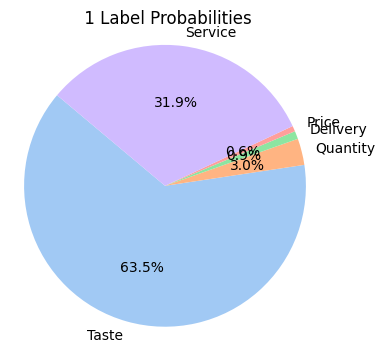

Review : 맛있어요 재주문 의사 있어요


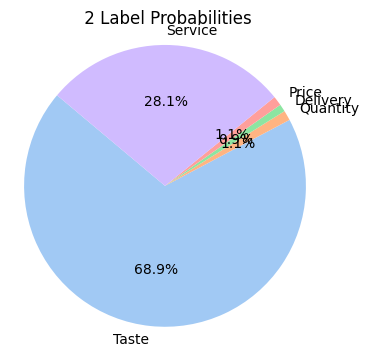

Review : 이가격에 이구성! 최고! 너무 맛있게 잘먹었습니다 


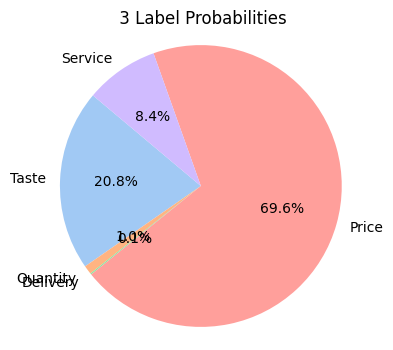

Review : 맛있게 잘 먹었어요


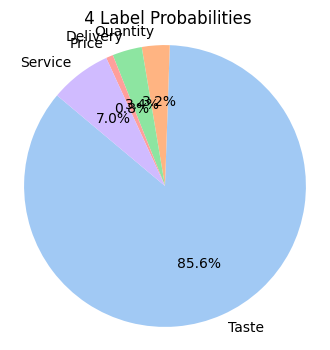

Review : 맛있게 잘 먹었어요. 김치찌개는 약간 김치국 느낌이긴 해요. 고기는 맛났고. 리뷰 서비스도 메뉴당 주시네요~ 또 주문하겠습니다


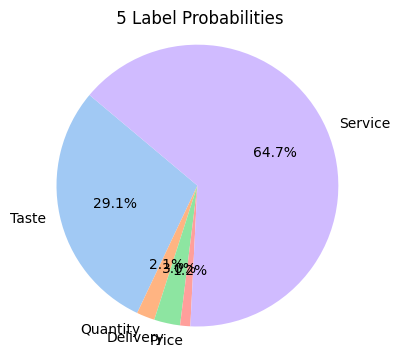

Review : 너무 맛있게 잘먹었습니다. 감사합니다 


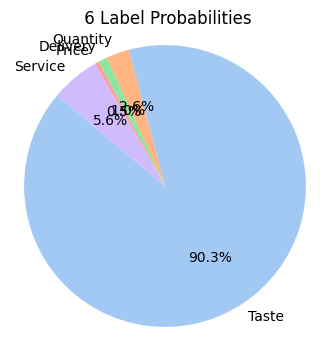

Review : 맛있어요! 양이 너무 많아요 배터질뻔. 서비스도 메뉴 수대로 주신거 센스 만점 서비스인데 너무 맛있었어요.미쳤음. 냉면도 잘하고 김치찌개 근본 참치김치찌개라 최고. 소스 안넣어도 간간해서 맛있었어요 라이더분이 바쁘셨는지 두고 문자 안주셔서 온 지 몰랐다가 나중에 나가보고 알아서 좀 배고파서 죽을 뻔 했는데. 그래도 30분정도 걸려온거라 넘 맛있게 밥 먹었어요! 한식 땡길때 완전 추천 모든 메뉴가 다 맛나요


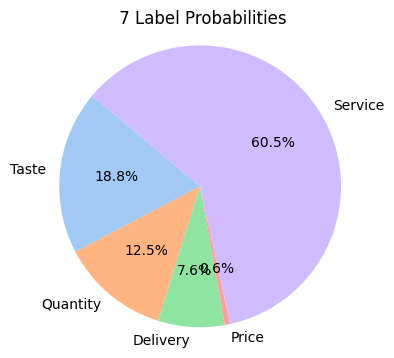

Review : 퀄리티도 좋고 맛도 맛있어요. 리뷰 이벤트 묵사발도 넘 맛있어요


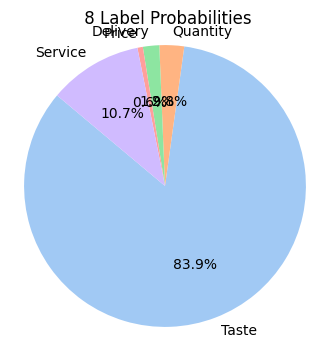

Review : 호다닥먹느라고 사진을 못찍었네요 . 늦게까지하고 푸짐하고 고기는 무조건 여기임!


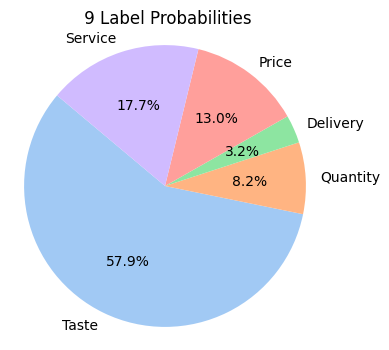

Review : 맛있게 잘먹었습니다 배달도 빨리오고 좋네요 감사합니다


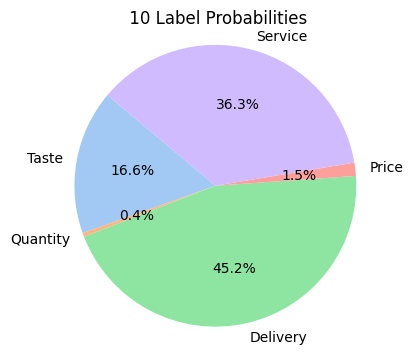

Review : 찌개 양은 많고 밥은 적당, 리뷰서비스는 조금만 덜 달면 더 맛있었겠어요.


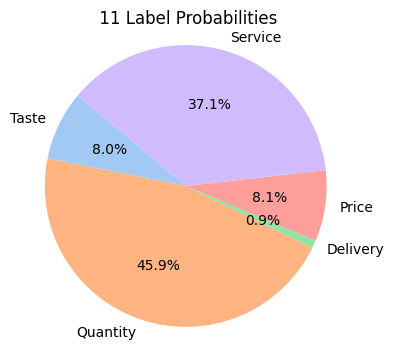

Review : 사진보다 실물이 백배 맛있어요~ 고기 양도 많아요~ 배달시간도 딱 맞춰서 보내주셨어요~


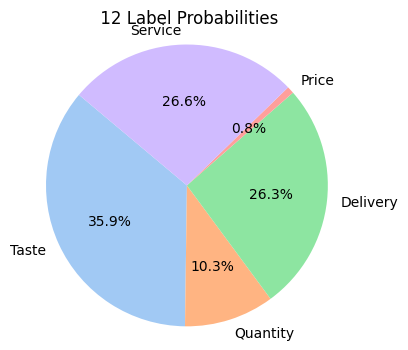

Review : 리뷰가 늦었네요. 맛있게 잘 먹었습니다. 또 시킬게요!


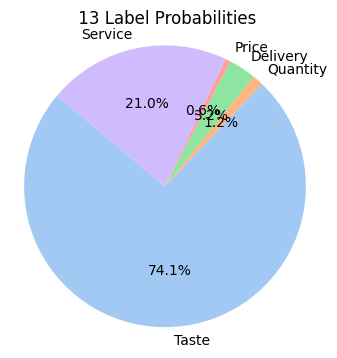

Review : 맛있어요 양도많구좋음


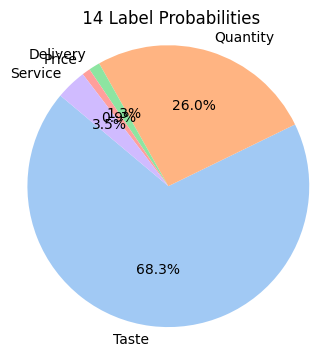

Review : 양많고 맛있었어요


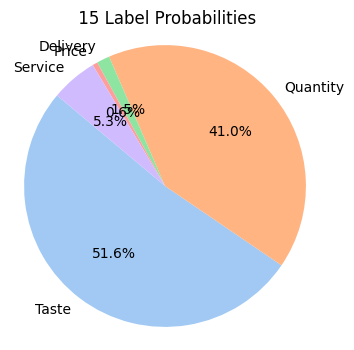

Review : 처음 주문했는데 맛있어서 다먹었어요 리뷰 묵사발도 꼭 드세요! 맛있게 잘먹었습니다 다음에 또 주문할게요


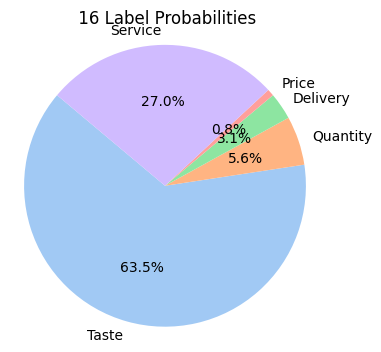

Review : 가성비 아주 만족 합니다. 맛있게 잘먹었습니다.


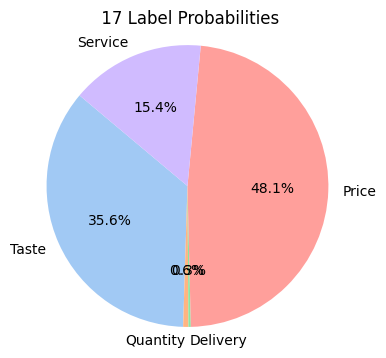

Review : 맛있게 먹었습니다!


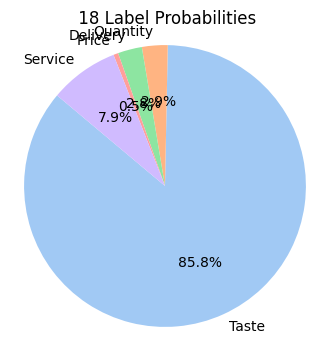

Review : 새벽부터 시켰는데 배송 시간 맞춰서 잘 와주셨고 도시락도 맛있고 묵사발도 맛있습니다~! 


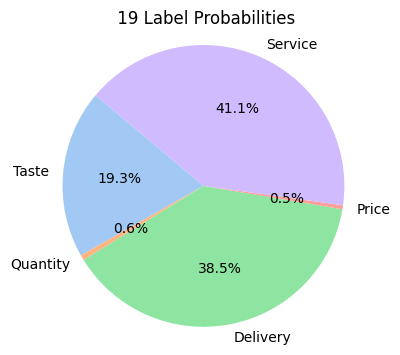

Review : 정말 간만에 리뷰이벤트 받았기 때문이 아닌 진짜 맛있어서 리뷰써요


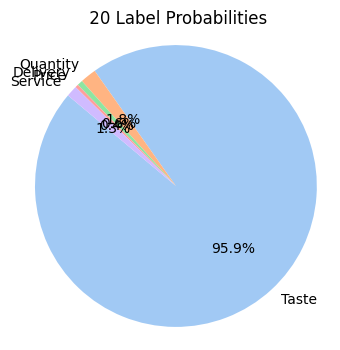

In [31]:
# 리뷰별 그래프 

import matplotlib.pyplot as plt
import seaborn as sns


# 예제 데이터
labels = ["Taste", 'Quantity', "Delivery", "Price", 'Service']


pastel_colors = sns.color_palette("pastel", len(labels))

# for j in range(df.shape[0]) : 
#     probabilities = total_scores_list[j]

# 각 리뷰별로 원형 그래프로 확률 시각화
for i, prob in enumerate(total_scores_list):
    max_prob = max(prob)  # 가장 큰 확률값 찾기
    adjusted_prob = [p / max_prob for p in prob]  # 비율을 최대값으로 나누어 조정
    print(f"Review : {review_df[i]}")
    plt.figure(figsize=(4, 4))  # 그래프 크기 최소화
    plt.pie(adjusted_prob, labels=labels, autopct='%1.1f%%', startangle=140, colors=pastel_colors)
    plt.title(f' {i+1} Label Probabilities')
    plt.axis('equal')  # 원형 그래프를 원형으로 유지
    plt.show()
    


In [32]:
result_df_reply

,reply,맛,양,배달,가격,서비스,best_label,second_label,ranking
0,고객님의 미소가 가득한 시간이 되길 항상 노력하겠습니다 다음에도 기회가 된다면 저희...,0.032668,0.026738,0.016437,0.014364,0.909793,맛,0,"[서비스, 맛, 양, 배달, 가격]"
1,행복한 시간 보내셨을까요? 맛있게 드시고 남겨주신 리뷰를 볼 때면 저희는 힘이 불끈...,0.666674,0.013696,0.013913,0.005788,0.299928,맛,0,"[맛, 서비스, 배달, 양, 가격]"
2,고객님의 마음속에 제대로 저장 될때까지~오늘도 아자아자 중독성 강한 저희 메뉴가 생...,0.244823,0.013041,0.006469,0.004745,0.730923,맛,0,"[서비스, 맛, 양, 배달, 가격]"
3,고객님도 항상 행복하시길 바라요!,0.046910,0.083268,0.062240,0.058904,0.748678,양,0,"[서비스, 양, 배달, 가격, 맛]"
4,저희 매장을 빛내 주셔서 영광입니다 맛있게 드셔 주신 것 만으로도 감사한데 이런 행...,0.781627,0.012185,0.000903,0.000419,0.204866,맛,0,"[맛, 서비스, 양, 배달, 가격]"
5,반갑습니다 저희 매장과 즐거운 시간 보내셨을까요? 정말 감사합니다 주신 리뷰 읽고 ...,0.626771,0.032761,0.005010,0.004119,0.331340,맛,0,"[맛, 서비스, 양, 배달, 가격]"
6,고객님께서 맛있다고 해 주신 저희 메뉴! 이대로 번창할 일만 남았군요~만족스럽게 드...,0.306490,0.004010,0.000441,0.000153,0.688906,맛,0,"[서비스, 맛, 양, 배달, 가격]"
7,맛있는 순간을 저희 브랜드와 함께 해주셔서 감사할 따름입니다 음식은 역시 맛이 가장...,0.983130,0.008199,0.000683,0.000407,0.007580,맛,0,"[맛, 양, 서비스, 배달, 가격]"
8,별점 5개와 리뷰를 잊지 않고 남겨주셔서 감사합니다 주문 해 주셨을 때 저희는 맛을...,0.604111,0.002918,0.001715,0.000562,0.390694,맛,0,"[맛, 서비스, 양, 배달, 가격]"
9,좋은 말씀으로 마음까지 따뜻하게 만들어주셔서 진심으로 감사드립니다 당연히 맛은 기본...,0.934770,0.041445,0.002746,0.001153,0.019886,맛,0,"[맛, 양, 서비스, 배달, 가격]"


In [33]:
df = result_df_reply[['맛','양','배달','가격']]
df

reply_df = result_df_reply['reply'].tolist()

total_scores_list = []

for i in range(df.shape[0]):
    lst = df.iloc[i].values.tolist()
    total_scores_list.append(lst)


Review : 고객님의 미소가 가득한 시간이 되길 항상 노력하겠습니다 다음에도 기회가 된다면 저희와 함께 즐거운 시간 보내시길 바라며, 오늘도 따뜻한 하루 되세요 


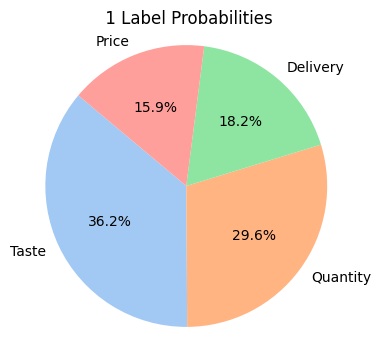

Review : 행복한 시간 보내셨을까요? 맛있게 드시고 남겨주신 리뷰를 볼 때면 저희는 힘이 불끈불끈 솟아난답니다 언제나 저희 매장의 문은 활짝 열려져 있으니, 생각나실 때마다 들려주세요 오늘도 행복한 하루 보내시길 바랄게요~


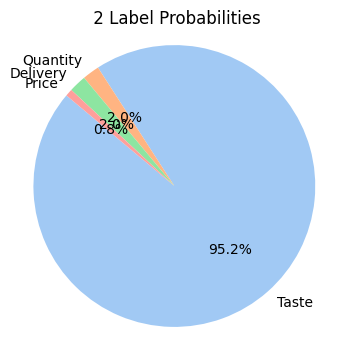

Review : 고객님의 마음속에 제대로 저장 될때까지~오늘도 아자아자 중독성 강한 저희 메뉴가 생각나실 때 다시 뵙길 바라요! 


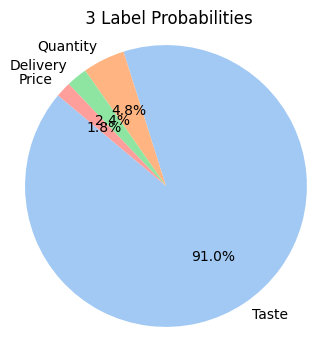

Review : 고객님도 항상 행복하시길 바라요! 


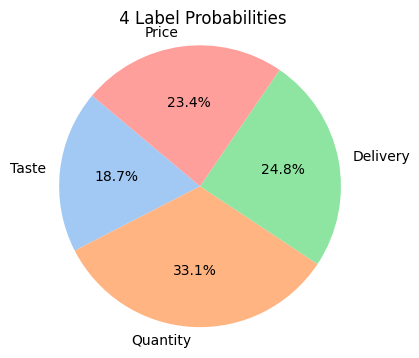

Review : 저희 매장을 빛내 주셔서 영광입니다 맛있게 드셔 주신 것 만으로도 감사한데 이런 행복감 주셔서 너무 감사합니다 골라 주신 메뉴로 만족감을 드리기 위해, 좋은 재료와 맛있는 레시피만 사용하겠습니다 지금보다 더 발전하고 꼼꼼히 챙기는 매장이 되기 위해 오늘도 힘내보겠습니다 너무나 감사합니다 


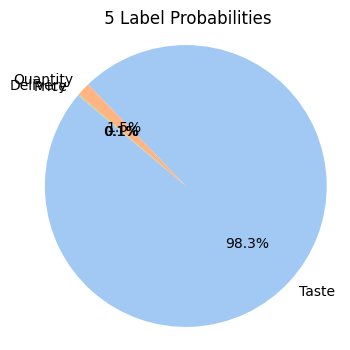

Review : 반갑습니다 저희 매장과 즐거운 시간 보내셨을까요? 정말 감사합니다 주신 리뷰 읽고 기분이 엄청 좋아졌어요 다음에 주문해 주셔도 이번과 같이 맛있게 드릴 수 있도록 방심하지 않고 있어야겠어요 하시는 일 모두 번창하시길 진심으로 바라고 있을게요 


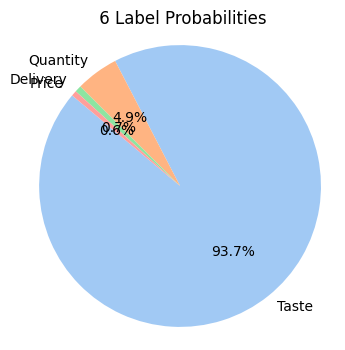

Review : 고객님께서 맛있다고 해 주신 저희 메뉴! 이대로 번창할 일만 남았군요~만족스럽게 드셔 주시기만 해도 너무 감사한데 오셔서 이렇게 칭찬까지 주셔서 몸 둘 바를 모르겠어요 정말 더 열심히 공부하고, 또 연습해서 계속 만족감 드리도록 하겠습니다! 오늘 그 누구보다 멋진 하루가 될 거예요! 


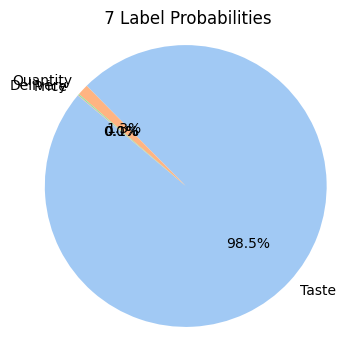

Review : 맛있는 순간을 저희 브랜드와 함께 해주셔서 감사할 따름입니다 음식은 역시 맛이 가장 기본인데, 그 기본을 칭찬해 주셔서 감동입니다 아직도 레시피 공부하고, 연습하고 있거든요 사실.더욱 잘 해서 계속 마음속에 남아 있고 싶습니다 앞으로도 행복한 하루 보내시길 바랄게요 


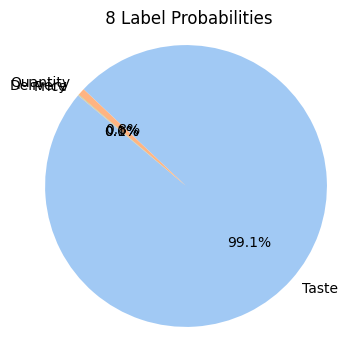

Review : 별점 5개와 리뷰를 잊지 않고 남겨주셔서 감사합니다 주문 해 주셨을 때 저희는 맛을 약속 드린다고 생각하고 있습니다 기대하시는 맛을 매번 드린다는 게 쉽지는 않지만! 이렇게 좋은 말씀 들을 수 있어 너무 보람 찬 것 같습니다 소중한 시간에 저희 매장 이용해주셔서 너무 감사드리고, 좋은 하루 되세요! 


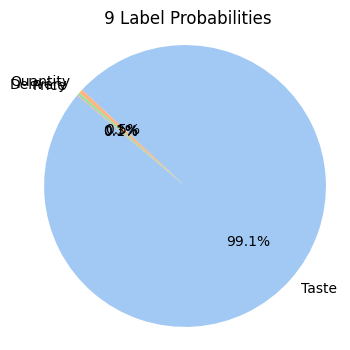

Review : 좋은 말씀으로 마음까지 따뜻하게 만들어주셔서 진심으로 감사드립니다 당연히 맛은 기본이 되어야 된다고 생각합니다 칭찬 주셔서 행복하네요 더욱 힘내서 이번과 같은 만족감 매번 드릴 수 있게 하겠습니다! 언제 어디서든 기분 좋은 일들만 가득하시길 바라요 


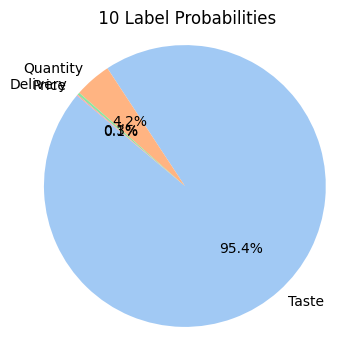

Review : 소중한 식사 시간에 저희 매장을 찾아 주셔서 감사드립니다. 저희를 찾아 주신 만큼 100 만족감을 드리고 싶었는데 그러지 못한 것 같아 아쉽습니다 소중한 의견 말씀해 주셔서 너무나도 감사드리며, 말씀 주신 음식 맛 부분에 대해서는 개선을 하여 추후에는 더욱더 큰 만족감을 드릴 수 있도록 하겠습니다! 저희 매장을 찾아 주셔서 다시 한번 감사의 말씀드리며, 언제나 행복한 순간들만 가득하시길 바라겠습니다!


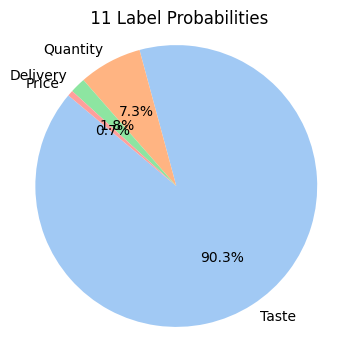

Review : 고객님의 마음을 잡기 위해 계속 노력하겠습니다 항상 건강 챙기시고, 오늘도 즐거운 하루 보내시길 바라겠습니다 


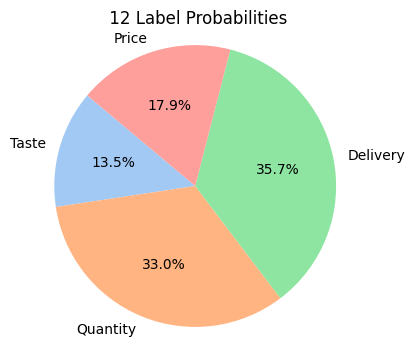

Review : 고객님께서 맛있다고 말씀 주시니 피로가 싹~ 사라지네요! 주방에서 힘든 일도 있고 늘 쉽지만은 않지만, 이런 리뷰 읽을 때 마다 보람차고 다시 시작할 수 있는 거 같습니다 정말 감사드려요 오늘도 화이팅 있게 마무리하시길 바라요 


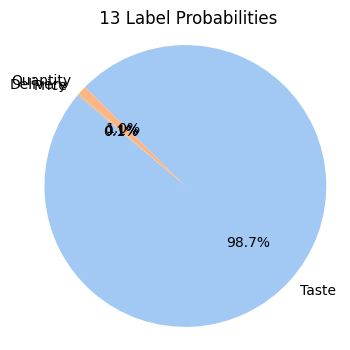

Review : 고객님! 늘 어떻게하면 더 맛있게 드릴 수 있을까 고민 많이 하고 있어요~항상 노력하고 발전하도록 하겠습니다 항상 같은 만족감 드릴 수 있도록 언제나 최선을 다해 운영 하겠습니다 


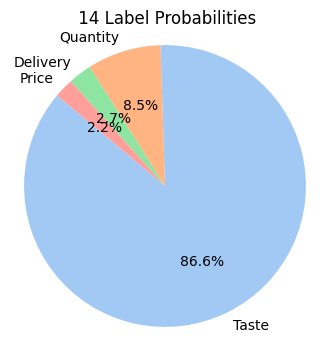

Review : 고객님들의 배고픔을 저희는 지켜만 볼 수 없습니다! 언제든지 행복한 배부름을 느끼게 해 드릴 수 있도록 저희가 있지 않겠습니까! 매번 찾아 주셔도 매번 시켜 먹고 싶은 매장이 되겠습니다 하시는 일 모두 번창하시길 진심으로 바라고 있을게요 


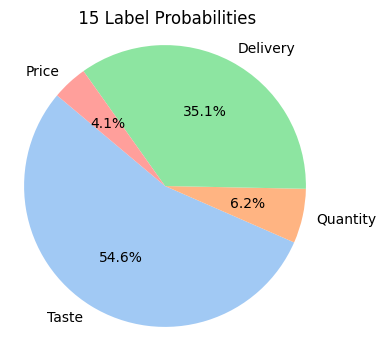

Review : 고객님이 완벽하게 행복하실 수 있도록 노력하겠습니다 언제든 신호만 주시면 바로 달려가는 매장이 되겠습니다! 다음에 또 만나요! 


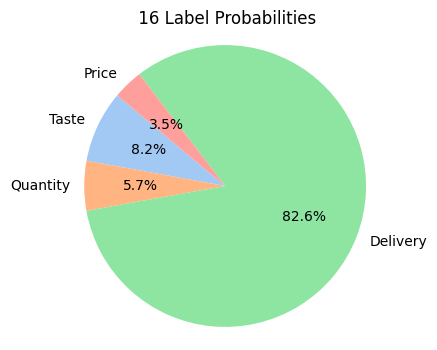

Review : 고객님의 신뢰에 항상 보답하는 매장이 되기 위해서 끊임없이 노력하겠습니다! 저희 매장 다시 와주실꺼죠? 언제든 신호만 주시면 바로 달려가도록 하겠습니다! 다음에 또 만나요! 


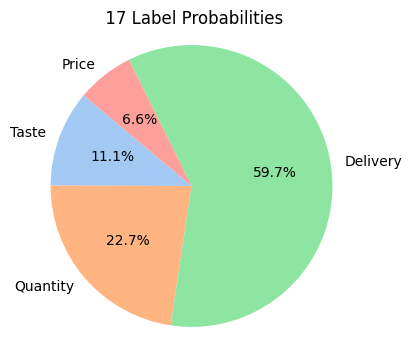

Review : 귀한 발걸음 감사합니다! 아낌없이 칭찬해 주셔서 기분이 좋습니다 저희 매장은 맛과 양, 서비스 등 모든 면에서 최고가 되기 위해 항상 최선을 다하고 있습니다! 또다시 저희 매장이 생각나실 때 만날 수 있길 바라고 있을게요~ 


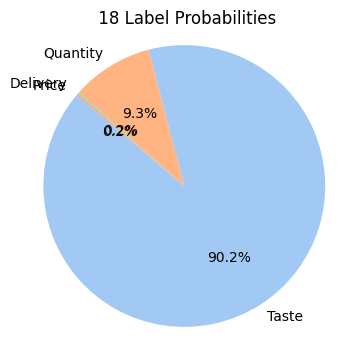

Review : 고객님의 리뷰는 저희를 성장시키는 원동력이 됩니다~ 내 가족, 내 친구가 먹는다는 마음으로 항상 더 나은 메뉴 드릴 수 있도록 정성껏 준비하겠습니다 저희 매장 찾아주셔서 감사의 말씀 드리며, 다음에 또 만나요 


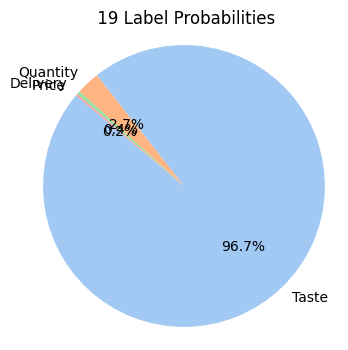

Review : 저희 매장과 즐거운 시간 보내셨을까요? 칭찬 감사합니다 늘 최선을 다해서 조리하고 있지만, 이렇게 맛있게 드셔 주셨다고 해주시는 리뷰 보면 정말 마음이 따듯해지더라고요 더 맛있게 드릴 수 있게 더 노력해야겠어요! 언제나 웃음 가득한 일들만 계속되시길 바라며, 행복한 하루 보내세요 


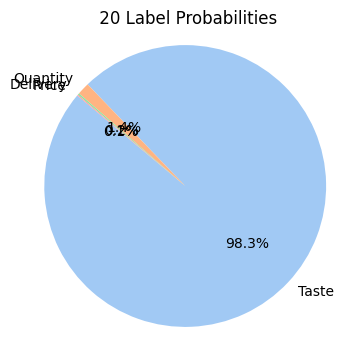

In [34]:

import matplotlib.pyplot as plt

# 예제 데이터
labels = ["Taste", 'Quantity', "Delivery", "Price"]

pastel_colors = sns.color_palette("pastel", len(labels))


# for j in range(df.shape[0]) : 
#     probabilities = total_scores_list[j]

# 각 리뷰별로 원형 그래프로 확률 시각화
for i, prob in enumerate(total_scores_list):
    max_prob = max(prob)  # 가장 큰 확률값 찾기
    adjusted_prob = [p / max_prob for p in prob]  # 비율을 최대값으로 나누어 조정
    print(f"Review : {reply_df[i]}")
    plt.figure(figsize=(4, 4))  # 그래프 크기 최소화
    plt.pie(adjusted_prob, labels=labels, autopct='%1.1f%%', startangle=140, colors = pastel_colors)
    plt.title(f' {i+1} Label Probabilities')
    plt.axis('equal')  # 원형 그래프를 원형으로 유지
    plt.show()

In [35]:
def find_assigned_labels(probabilities, labels, threshold=0.5):
    assigned_labels = []
    for prob_values in probabilities:
        assigned = [labels[i] for i, value in enumerate(prob_values) if value >= threshold]
        assigned_labels.append(assigned)
    return assigned_labels


# 리뷰 - 답변 매칭

In [36]:

review = '너무 너무 맛있어요. 또 시켜먹을거에요. 배달은 늦었지만 너무 맛있는...'

data = [
    (0.29192861914634705, '배달 소요시간은 매우 지체되었어요? 다음에는 더욱 신속하게 도착하도록 노력하겠습니다. 오늘 주신 만족하실 수 있도록 다음 번에는 더 좋은 서비스를 제공해드릴게니다. 감사합니다. '),
    (0.21787649393081665, '불편하셨다니 죄송합니다. 더 좋은 서비스로 보답하겠습니다. 감사합니다! '),
    (0.36433345079421997, '배달이 늦게 와서 실망스러우셨군요 죄송합니다. 더 빠른 시간에 배달을 해드릴 수 있도록 노력하겠습니다. 감사합니다! 저희 음식은 항상 신선하고 따뜻한 상태로 고객님들께 제공하도록 노력하고 있습니다. 이용해 주셔서 정말 고맙습니다, 짭짤한 맛을 느끼실 겁니다. 앞으로도 많은 사랑과 관심 부탁드리겠어요, 다음번에는 만족스러운 음식을 맛볼수 있는 음식과 함께 보답해 드리도록 하겠습니다.\n 다시 한 번 심려를 '),
    (0.32460707426071167, '맛있게 드시지 못하셨다니 저희의 부족한 서비스에 대해 크게 반성하게 됩니다. 더 나은 맛과 서비스로 보답하도록 하겠습니다. 감사합니다. 캥거루를 조심하지 말고 다시 한 번 주문해주세요! 다음에 기회가 된다면 빨리 달려갈 것을 약속드립니다 존경한다 합니다. 양해 부탁드려 죄송하다는 말씀드리며, 다음에는 좋은 경험을 제공할 수 있도록 노력하겠습니다, 후추 달아 먹기 전에 추가 제공된 게 아닌, 실수로 불편함을 끼쳐 정말 진심으로 '),
    (0.3593043088912964, '맛있는 음식을 제공하는 것이 저의 핵심 가치 중 하나이기 때문에, 배달이 늦은 것은 정말 죄송합니다. 꿔 먹은 음식이 더 맛이 좋다니 다음 번에는 이 점을 개선해보도록 하겠습니다. 불편을 끼쳐드려 대단히 반성하며, 앞으로는 더욱 신속하고 정확한 서비스를 제공하도록 노력하겠습니다. 감사입니다. 이용해주셔서 다시 한 번의 사과의 말씀 전하는데, 기대에 못 미쳤다는 점 양해 부탁드립니다. 다음에 기회를 주신다면 만족할 만한 맛을 경험하실 수 있도록 ')
]

texts = []

for score, text in data:
    texts.append(text)

print(texts)


['배달 소요시간은 매우 지체되었어요? 다음에는 더욱 신속하게 도착하도록 노력하겠습니다. 오늘 주신 만족하실 수 있도록 다음 번에는 더 좋은 서비스를 제공해드릴게니다. 감사합니다. ', '불편하셨다니 죄송합니다. 더 좋은 서비스로 보답하겠습니다. 감사합니다! ', '배달이 늦게 와서 실망스러우셨군요 죄송합니다. 더 빠른 시간에 배달을 해드릴 수 있도록 노력하겠습니다. 감사합니다! 저희 음식은 항상 신선하고 따뜻한 상태로 고객님들께 제공하도록 노력하고 있습니다. 이용해 주셔서 정말 고맙습니다, 짭짤한 맛을 느끼실 겁니다. 앞으로도 많은 사랑과 관심 부탁드리겠어요, 다음번에는 만족스러운 음식을 맛볼수 있는 음식과 함께 보답해 드리도록 하겠습니다.\n 다시 한 번 심려를 ', '맛있게 드시지 못하셨다니 저희의 부족한 서비스에 대해 크게 반성하게 됩니다. 더 나은 맛과 서비스로 보답하도록 하겠습니다. 감사합니다. 캥거루를 조심하지 말고 다시 한 번 주문해주세요! 다음에 기회가 된다면 빨리 달려갈 것을 약속드립니다 존경한다 합니다. 양해 부탁드려 죄송하다는 말씀드리며, 다음에는 좋은 경험을 제공할 수 있도록 노력하겠습니다, 후추 달아 먹기 전에 추가 제공된 게 아닌, 실수로 불편함을 끼쳐 정말 진심으로 ', '맛있는 음식을 제공하는 것이 저의 핵심 가치 중 하나이기 때문에, 배달이 늦은 것은 정말 죄송합니다. 꿔 먹은 음식이 더 맛이 좋다니 다음 번에는 이 점을 개선해보도록 하겠습니다. 불편을 끼쳐드려 대단히 반성하며, 앞으로는 더욱 신속하고 정확한 서비스를 제공하도록 노력하겠습니다. 감사입니다. 이용해주셔서 다시 한 번의 사과의 말씀 전하는데, 기대에 못 미쳤다는 점 양해 부탁드립니다. 다음에 기회를 주신다면 만족할 만한 맛을 경험하실 수 있도록 ']


In [49]:
review_example = review

reply_candidate_example = texts

In [53]:
example_scores= extract_scores(reply_candidate_example, candidate_labels)

In [55]:
# example_scores_review= extract_scores(review_example, candidate_labels)

In [60]:
candidate_labels = ["맛", "양", "배달", "가격", "서비스"]

example_score_list = []
# 각 라벨에 대한 평균 스코어 계산 및 출력
for label in candidate_labels:
    label_mean = sum(example_scores[label]) / len(example_scores[label])
    print(f'{label} 평균 : {label_mean}')
    example_score_list.append(label_mean)


맛 평균 : 0.08890290171839296
양 평균 : 0.06870726896449923
배달 평균 : 0.34405719535425305
가격 평균 : 0.001627253758488223
서비스 평균 : 0.4967053920030594


In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# 예제 데이터
labels = ["Taste", 'Quantity', "Delivery", "Price", "Service"]
pastel_colors = sns.color_palette("pastel", len(labels))

def plot_label_probabilities(total_scores_list, labels=labels, colors=pastel_colors):
    for i, prob in enumerate(total_scores_list):
        max_prob = max(prob)  # 가장 큰 확률값 찾기
        adjusted_prob = [p / max_prob for p in prob]  # 비율을 최대값으로 나누어 조정

        plt.figure(figsize=(4, 4))  # 그래프 크기 최소화
        plt.pie(adjusted_prob, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
        plt.title(f'Review {i+1} Label Probabilities')
        plt.axis('equal')  # 원형 그래프를 원형으로 유지
        plt.show()


In [62]:
plot_label_probabilities(example_score_list)

TypeError: 'float' object is not iterable

# 답변 생성

In [82]:
# AutoModelForCausalLM 인과 관련 사용
from transformers import AutoTokenizer, AutoModelForCausalLM



model_name = "skt/kogpt2-base-v2"

# AutoModelForCausalLM 인과 관련 사용
from transformers import AutoTokenizer, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(model_name)

tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          bos_token='</s>',
                                          eos_token='</s>',
                                          unk_token='<unk>',
                                          pad_token='<pad>',
                                          mask_token='<mask>',
                                          max_len=1024)

loaded_model = AutoModelForCausalLM.from_pretrained(f"{DATA_PATH}0908_gpt_freeze_all").to(device)

In [14]:
!pip install -U sentence-transformers

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 0.18ubuntu0.18.04.1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [104]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer

bert_model = SentenceTransformer('jhgan/ko-sroberta-multitask')

def jaccard_similarity(text1, text2):
    # 문장을 단어로 분할 (또는 집합으로 변환)
    words1 = set(text1.split())
    words2 = set(text2.split())
    
    # 자카드 유사도 계산
    intersection = len(words1.intersection(words2))
    union = len(words1) + len(words2) - intersection
    
    if union == 0:
        return 0.0
    else:
        return float(intersection) / union

def evaluate_similarity(input_text, generated_text):
    input_embedding = bert_model.encode(input_text)
    generated_embedding = bert_model.encode(generated_text)

    # BERT 임베딩 기반 코사인 유사도
    cosine_similarity = 1 - pairwise_distances([input_embedding], [generated_embedding], metric='cosine')[0][0]

    # 자카드 유사도
    jaccard_sim = jaccard_similarity(input_text, generated_text)

    # 코사인 유사도와 자카드 유사도를 5:5 비중으로 조합
    combined_similarity = 0.5 * cosine_similarity + 0.5 * jaccard_sim

    return combined_similarity



In [105]:

# 예제
input_text = "음식이 맛있어요. 배달은 빨랐는데 양이 조금 적은 건 아쉽네요 "
generated_text = "맛있는 저희 매장 음식을 먹어주셔서 감사합니다. 배달이 느려서 죄송합니다. "
combined_sim = evaluate_similarity(input_text, generated_text)

print("Combined Similarity:", combined_sim)

Combined Similarity: 0.3374199867248535


In [106]:
# 옵션
from transformers import pipeline
pipe = pipeline("text2text-generation", model="lcw99/t5-base-korean-paraphrase")

def paraphrase_text(text):
    generated_text = pipe(text, max_length=512, early_stopping=True,
                          num_beams=4,
                          num_return_sequences=2,
                          no_repeat_ngram_size=4,
                          top_k=50,
                          top_p=0.95)
    generated_text = generated_text[0]['generated_text']
    return generated_text

In [110]:
def chatbot_with_evaluation(model, tokenizer, max_len, device, num_samples=5):
    model.eval()
    while True:
        text = input("user > ").strip()
        if text == "quit":
            break

        text = "<q>" + text + "</s><a>"
        x = tokenizer.encode(text, return_tensors="pt").to(device)
        q_len = len(text) + 1

        best_generated_text = None
        best_similarity_score = -1.0
        generated_texts = []  # 답변 후보군을 담을 리스트
        for i in range(num_samples):
            result_ids = model.generate(x,
                                        max_length=max_len,
                                        repetition_penalty=2.0,
                                        use_cache=True,
                                        do_sample=True,
                                        temperature=0.9,
                                        top_k=50,
                                        num_return_sequences=1
                                        )
            generated_text = tokenizer.decode(result_ids[0])
            generated_text = generated_text[q_len:-4]
            # generated_text = paraphrase_text(generated_text)

            similarity_score = evaluate_similarity(text, generated_text)
            generated_texts.append((similarity_score,generated_text))

            # candidate_labels = ["맛", '양', "배달", "가격", '서비스']
            # extract_scores(text, candidate_labels)
            # extract_scores(generated_texts, candidate_labels)

            print(generated_texts[i])

            if similarity_score > best_similarity_score:
                best_similarity_score = similarity_score
                best_generated_text = generated_text

        print()
        print("Best_reply >", best_generated_text)
        print("Best_similarity_score:", best_similarity_score)
        print("--------------------------------------------------------------------------------------------")


In [ ]:
chatbot_with_evaluation(loaded_model,tokenizer,128,device)

user >  너무 너무 맛있어요. 또 시켜먹을거에요. 배달은 늦었지만 너무 맛있는...


(0.29192861914634705, '배달 소요시간은 매우 지체되었어요? 다음에는 더욱 신속하게 도착하도록 노력하겠습니다. 오늘 주신 만족하실 수 있도록 다음 번에는 더 좋은 서비스를 제공해드릴게니다. 감사합니다. ')
(0.21787649393081665, '불편하셨다니 죄송합니다. 더 좋은 서비스로 보답하겠습니다. 감사합니다! ')
(0.36433345079421997, '배달이 늦게 와서 실망스러우셨군요 죄송합니다. 더 빠른 시간에 배달을 해드릴 수 있도록 노력하겠습니다. 감사합니다! 저희 음식은 항상 신선하고 따뜻한 상태로 고객님들께 제공하도록 노력하고 있습니다. 이용해 주셔서 정말 고맙습니다, 짭짤한 맛을 느끼실 겁니다. 앞으로도 많은 사랑과 관심 부탁드리겠어요, 다음번에는 만족스러운 음식을 맛볼수 있는 음식과 함께 보답해 드리도록 하겠습니다.\n 다시 한 번 심려를 ')
(0.32460707426071167, '맛있게 드시지 못하셨다니 저희의 부족한 서비스에 대해 크게 반성하게 됩니다. 더 나은 맛과 서비스로 보답하도록 하겠습니다. 감사합니다. 캥거루를 조심하지 말고 다시 한 번 주문해주세요! 다음에 기회가 된다면 빨리 달려갈 것을 약속드립니다 존경한다 합니다. 양해 부탁드려 죄송하다는 말씀드리며, 다음에는 좋은 경험을 제공할 수 있도록 노력하겠습니다, 후추 달아 먹기 전에 추가 제공된 게 아닌, 실수로 불편함을 끼쳐 정말 진심으로 ')
(0.3593043088912964, '맛있는 음식을 제공하는 것이 저의 핵심 가치 중 하나이기 때문에, 배달이 늦은 것은 정말 죄송합니다. 꿔 먹은 음식이 더 맛이 좋다니 다음 번에는 이 점을 개선해보도록 하겠습니다. 불편을 끼쳐드려 대단히 반성하며, 앞으로는 더욱 신속하고 정확한 서비스를 제공하도록 노력하겠습니다. 감사입니다. 이용해주셔서 다시 한 번의 사과의 말씀 전하는데, 기대에 못 미쳤다는 점 양해 부탁드립니다. 다음에 기회를 주신다면 만족할 만한 맛을 경험하실 수 있도록')

Best_reply > 배